In [12]:
from fastai.vision.data import DataBlock
from fastai.vision.data import ImageBlock, CategoryBlock
from fastai.vision.data import get_image_files, parent_label
from fastai.vision.data import RandomSplitter
from fastai.vision.augment import Resize, RandomResizedCrop, aug_transforms
from fastai.vision.learner import vision_learner
from fastai.vision.models import resnet18
from fastai.metrics import accuracy, error_rate
from fastai.callback.schedule import lr_find
from fastai.callback.schedule import fit_one_cycle
from fastai.interpret import ClassificationInterpretation
from fastai.learner import load_learner
import ipywidgets as widgets


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = "/content/drive/MyDrive/DeepLearningForCoders/BearClassifier/bears/"

SIZE = 128
BATCH_SIZE = 16

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(SIZE))

dls = bears.dataloaders(PATH, bs=BATCH_SIZE)

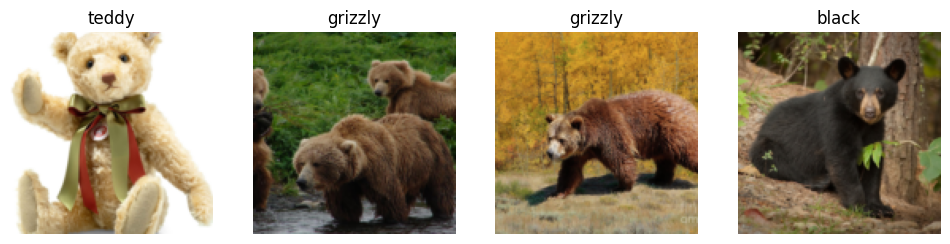

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fit_one_cycle(10, 1e-3)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.388976,0.440359,0.210526,01:13
1,0.864343,0.049546,0.017544,00:46
2,0.558546,0.031630,0.000000,00:45
3,0.399317,0.031861,0.000000,00:46
4,0.321715,0.037756,0.017544,00:46
5,0.248142,0.056805,0.035088,00:46
6,0.211175,0.057232,0.035088,00:46
7,0.166514,0.050971,0.035088,00:46
8,0.130034,0.057008,0.035088,00:51
9,0.117550,0.048404,0.017544,00:45


In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, 0.2),
    batch_tfms=aug_transforms()
)
dls = bears.dataloaders(PATH, bs=BATCH_SIZE)
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.698359,0.423396,0.157895,01:10
1,1.075986,0.039395,0.017544,01:08
2,0.688909,0.017605,0.000000,01:07
3,0.510751,0.009060,0.000000,01:09
4,0.384265,0.006338,0.000000,01:11
5,0.320932,0.005865,0.000000,01:08
6,0.270350,0.002952,0.000000,01:09
7,0.226260,0.003420,0.000000,01:08
8,0.184096,0.003129,0.000000,01:08
9,0.161011,0.004064,0.000000,01:08


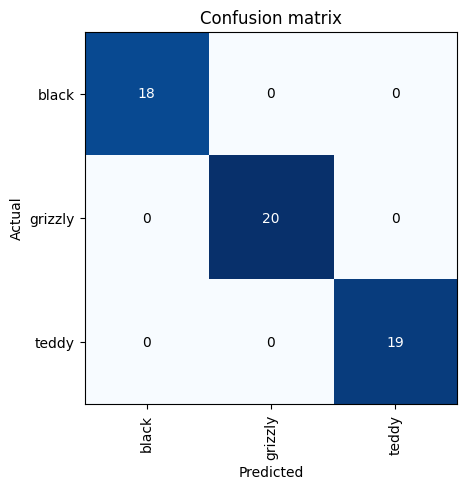

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

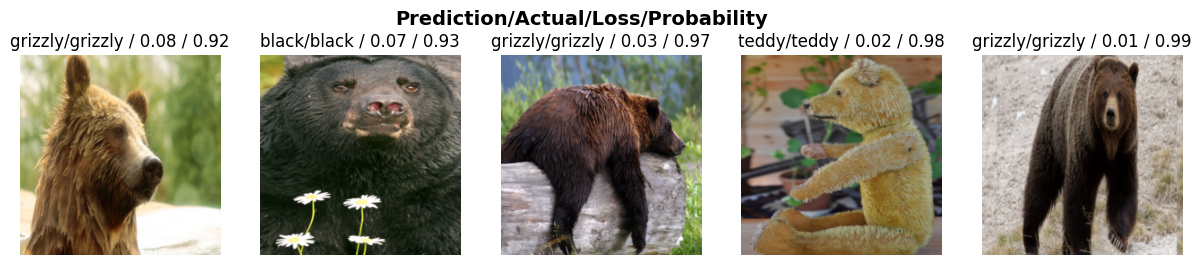

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
learn.export()

In [19]:
MODEL_DIR = "/content/drive/MyDrive/DeepLearningForCoders/BearClassifier/export.pkl"
learn_inf = load_learner(MODEL_DIR)
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [20]:
TEST_DIR = "/content/drive/MyDrive/DeepLearningForCoders/BearClassifier/bear_test.jpeg"
learn_inf.predict(TEST_DIR)

('teddy', tensor(2), tensor([6.6647e-06, 7.3986e-05, 9.9992e-01]))

In [30]:
from ipywidgets.widgets.widget_box import VBox
from PIL import Image
from io import BytesIO

btn_upload = widgets.FileUpload()

img = Image.open(TEST_DIR)
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

lbl_pred = widgets.Label()
lbl_pred

btn_run = widgets.Button(description="Classify")
btn_run

def on_click_classify(change):
  img = BytesIO(btn_upload.data[-1])
  img = Image.open(img)
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred, pred_idx, probs = learn_inf.predict(img)
  lbl_pred.value = f"Prediction: {pred} -- Probability: {probs[pred_idx]:.04f}"


btn_run.on_click(on_click_classify)

VBox([widgets.Label("Select your bear!"), btn_upload, btn_run, out_pl, lbl_pred])